# $\beta$'s Normality

In the following notebook we show empirical evidence that the $\beta$'s of a logistic regression model are normally distributed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from scipy import stats

from joblib import Parallel, delayed
from tqdm import tqdm


SEED = 42
np.random.seed(SEED)

We load our example dataset

In [2]:
df = pd.read_csv("../../data/train_rose.csv")

X, y = df.drop(columns=["CARAVAN"]), df["CARAVAN"]

In [3]:
df.describe()

,MAANTHUI,MGEMLEEF,MOSHOOFD.1,MOSHOOFD.2,MOSHOOFD.3,MOSHOOFD.4,MOSHOOFD.5,MOSHOOFD.6,MOSHOOFD.7,MOSHOOFD.8,...,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN,MMGEMLEEF
count,10948.000000,10948.000000,10948.000000,10948.000000,10948.000000,10948.000000,10948.000000,10948.000000,10948.000000,10948.000000,...,10948.000000,10948.000000,10948.000000,10948.000000,10948.000000,10948.000000,10948.000000,10948.000000,10948.000000,10948.000000
mean,0.011052,2.998265,0.012696,0.015021,0.017893,0.000528,0.007926,0.002629,0.008657,0.029463,...,0.001451,0.000781,0.070688,0.000142,0.002395,0.005217,0.001198,0.003278,0.500000,0.044406
std,0.039259,0.793285,0.035350,0.037993,0.040842,0.007640,0.028600,0.016887,0.029783,0.049049,...,0.012616,0.009760,0.059791,0.003971,0.017479,0.029922,0.011571,0.018862,0.500023,0.017629
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222
50%,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.044444
75%,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,...,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.044444
max,1.000000,6.000000,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,...,0.111111,0.222222,0.777778,0.111111,0.222222,0.333333,0.222222,0.222222,1.000000,0.111111


Define the number of bootstrap samples to generate

In [4]:
n_bootstraps = 5000
coef_dists = []

In [5]:
perc_bs = 0.4
n_bs = int(n_bootstraps * perc_bs)

def resample(X, y, n):
    idx = np.random.choice(X.index, size=int(n), replace=False)
    return X.loc[idx], y.loc[idx]

def bernoulli_subbagging(X ,y , p):
    ber = np.random.binomial(1, p, size=len(y))
    return X[ber == 1], y[ber == 1]

We start the simulation by resampling the data and fitting a logistic regression model to each resampled dataset. We then store the coefficients of the model in a list. This process is repeated 1000 times. The coefficients are then plotted as a histogram. The histogram shows the distribution of the coefficients.

In [6]:
def bootstrap_fit_model(X, y, perc_bs):
    # Calculate sample size
    # sample_size = int(perc_bs * len(X))
    # Bootstrap sample
    X_sample, y_sample = bernoulli_subbagging(X, y, perc_bs)
    
    # Fit logistic regression model
    model = LogisticRegression(solver="liblinear")
    model.fit(X_sample, y_sample)
    
    # Return the coefficients
    coeffs = model.intercept_.tolist() + model.coef_[0].tolist()
    
    return np.array(coeffs)

In [7]:
tasks = (delayed(bootstrap_fit_model)(X, y, perc_bs) for _ in range(n_bootstraps))
coef_dists = Parallel(n_jobs=-1)(tqdm(tasks, total=n_bootstraps, desc="Bootstrapping"))

coef_dists = np.array(coef_dists)

Bootstrapping: 100%|██████████| 5000/5000 [01:33<00:00, 53.72it/s]


In [8]:
# Save the coefficients with joblib
from joblib import dump
dump(coef_dists, "coef_dists.np.joblib", compress=3)

['coef_dists.np.joblib']

In [9]:
coef_dists.shape

(5000, 66)

## Estimation of the distribution of $\hat{\beta}$

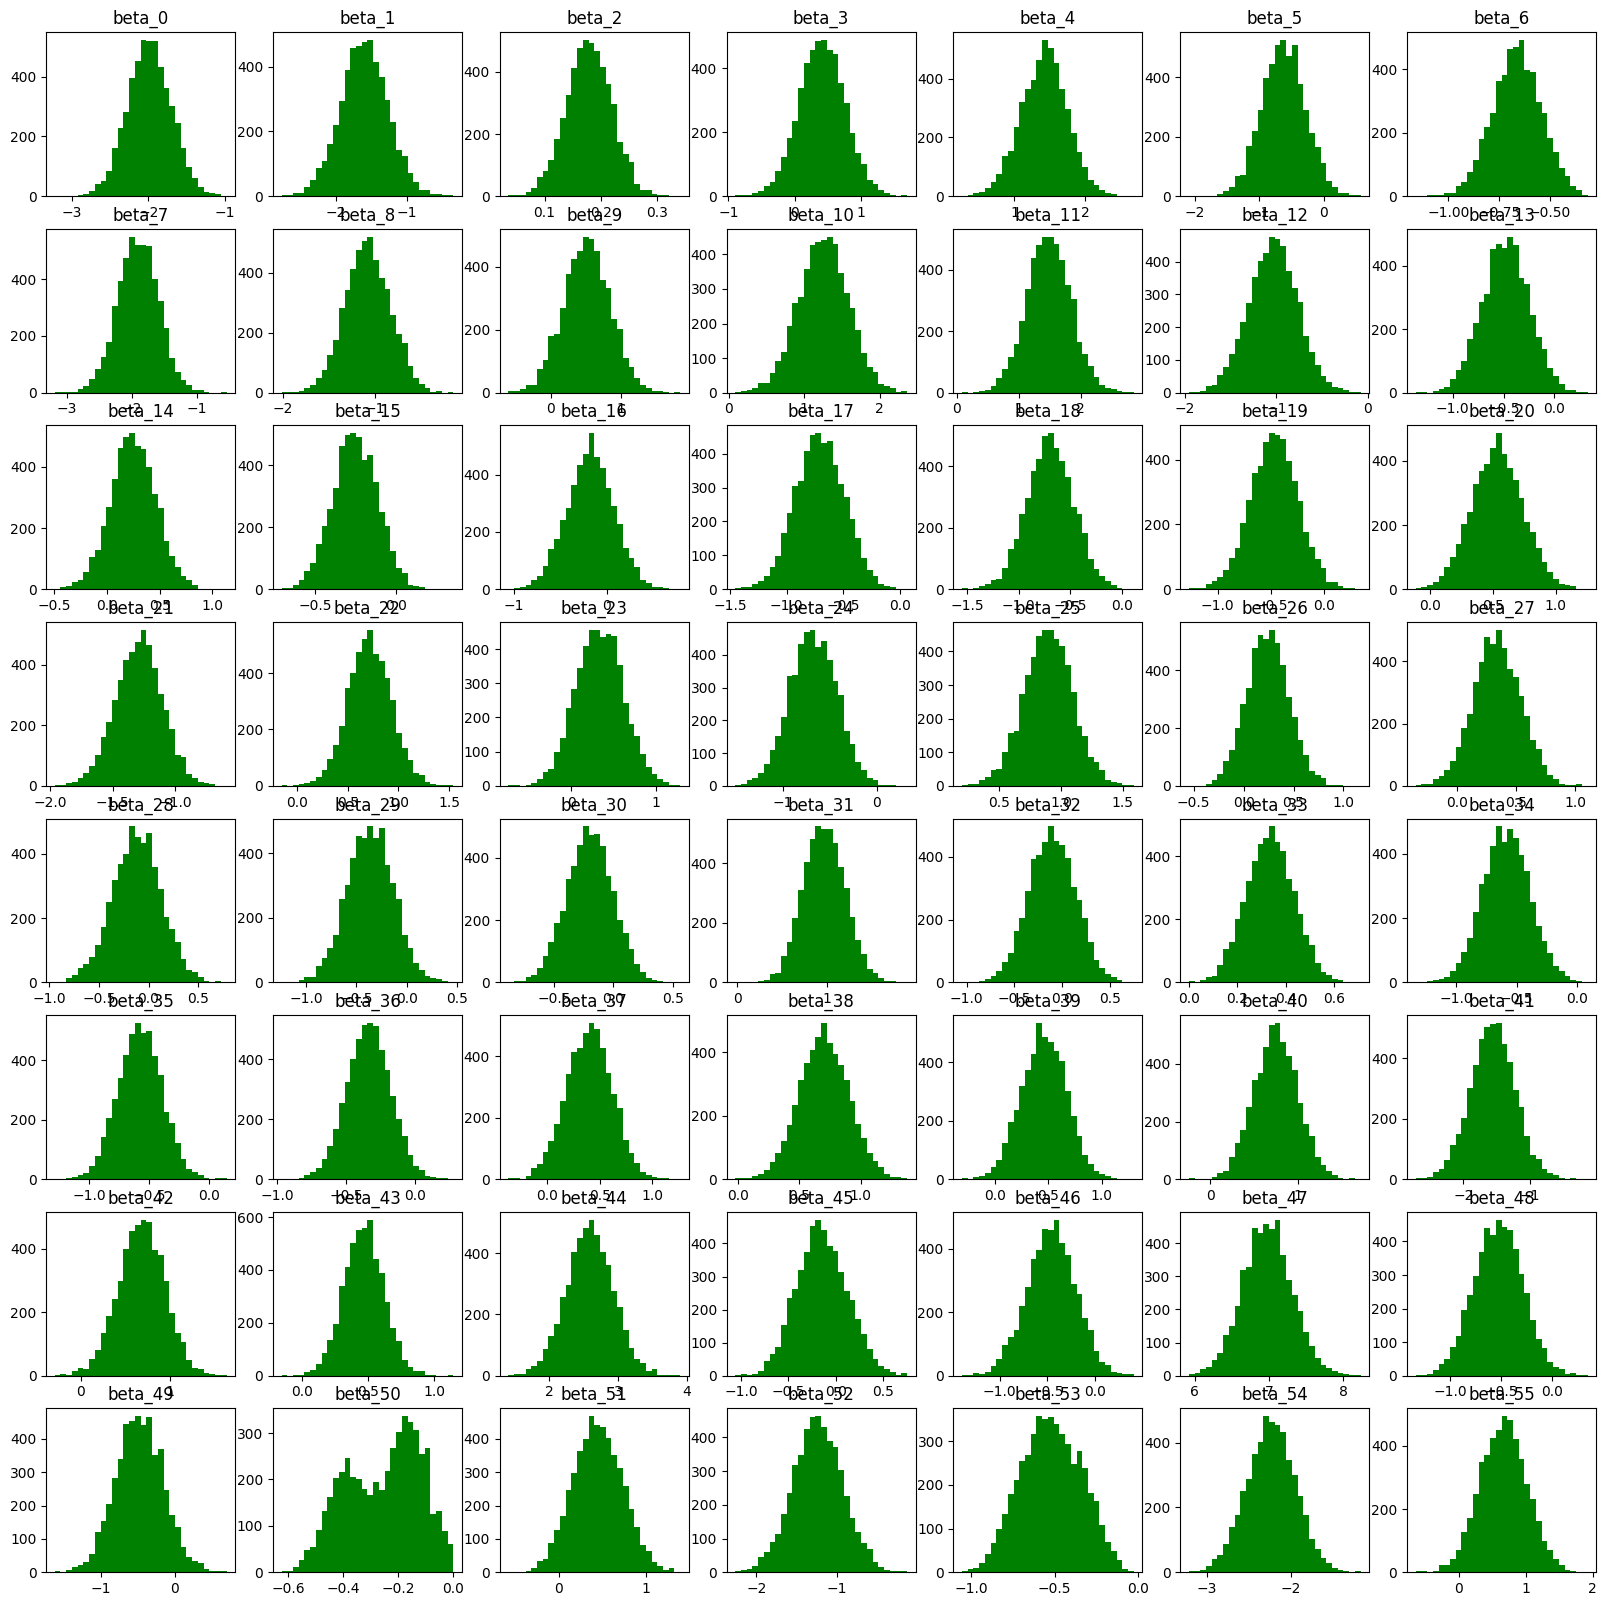

In [10]:
# Histogram of the bootstrapped betas 5 columns 10 rows
fig, ax = plt.subplots(8, 7, figsize=(20, 20))

for i in range(8):
    for j in range(7):
        _beta = coef_dists[:, i * 7 + j]
        
        ax[i, j].hist(_beta, bins=30, color="g")
        ax[i, j].set_title(f"beta_{i * 7 + j}")


## Hypothesis tests

After a visual inspection of the histogram, we can perform a more formal test to check if the coefficients are normally distributed. We will use the following test:
- Shapiro-Wilk test
- Kolmogorov-Smirnov test

In [11]:
from scipy import stats
from tabulate import tabulate

In [20]:
# Significance level 0.1%
alpha = 0.01

p_values = dict()

**Shapiro-Wilk test**
$$
W = \frac{\left(\sum_{i=1}^{n} a_i x_{(i)}\right)^2}{\sum_{i=1}^{n} (x_i - \bar{x})^2}
$$
where $x_{(i)}$ is the i-th order statistic, $\bar{x}$ is the sample mean, and $a_i$ are constants. The test statistic W is approximately normally distributed under the null hypothesis.

In [21]:
for i in range(coef_dists.shape[1]):
    _beta = coef_dists[:, i]
    
    sq = stats.shapiro(_beta)
    ks = stats.kstest(
        (_beta - np.mean(_beta)) / np.std(_beta), "norm"
    )
    
    p_values[i] = (sq.pvalue, ks.pvalue)

In [22]:
p_values = pd.DataFrame(p_values, index=["Shapiro-Wilk", "Kolmogorov-Smirnov"]).T

In [23]:
p_values['Shapiro-Wilk Normality'] = p_values['Shapiro-Wilk'] > alpha
p_values['Kolmogorov-Smirnov Normality'] = p_values['Kolmogorov-Smirnov'] > alpha

In [24]:
not_normal_sw = np.sum(p_values['Shapiro-Wilk Normality'] == False)
not_normal_ks = np.sum(p_values['Kolmogorov-Smirnov Normality'] == False)

In [25]:
print(f"Shapiro-Wilk: {not_normal_sw}/{len(p_values)}")
print(f"Kolmogorov-Smirnov: {not_normal_ks}/{len(p_values)}")

Shapiro-Wilk: 4/66
Kolmogorov-Smirnov: 2/66


Both tests indicate that the coefficients follow a normal distribution.

## Independence of the coefficients

<Axes: >

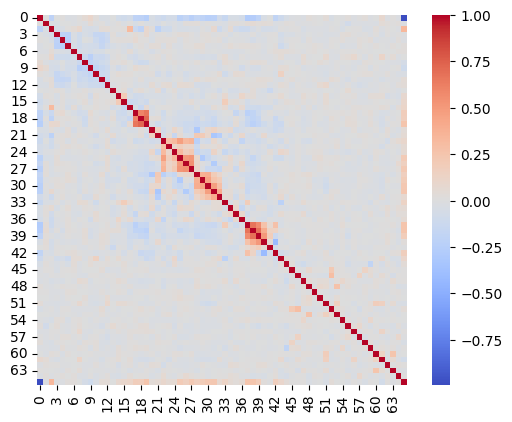

In [18]:
corr = np.corrcoef(coef_dists, rowvar=False)
sns.heatmap(corr,cmap="coolwarm", cbar=True, square=True)

## Transformation

We now consider the following transformation:

$$
Y \sim \frac{1}{1+e^{x^T\beta}}
$$

We now that $ \eta_{\beta} = e^{x^T\beta} \sim \text{Lognormal}(\mu_{\beta}, \sigma^2_{\beta}) $. However, Y does not follow a know distribution.

In [120]:
# randomly choose n data points from X
n = 100
idx = np.random.choice(X.index, size=n, replace=False)
xs = X.loc[idx]

In [122]:
etas = coef_dists[:,1:].dot(xs.T)

PROVA

In [117]:
alpha = 0.05

print(f"Shapiro-Wilk Normality: {sq.pvalue > alpha}")
print(f"Kolmogorov-Smirnov Normality: {ks.pvalue > alpha}")

Shapiro-Wilk Normality: True
Kolmogorov-Smirnov Normality: True
